# 01 - Quickstart: CPU vs GPU Timing + Truncation Accuracy

This notebook answers two practical questions:
1. How much faster is evaluation on GPU vs CPU?
2. How do truncation knobs change speed and exactness?

Core objects:
- `circuit`: parameterized quantum program (`CliffordGate` + `PauliRotation`)
- `observables`: target operators whose expectation values we evaluate
- `program = compile_expval_program(...)`: compiled surrogate used for repeated inference


In [1]:
import os
import sys
import time

try:
    cwd = os.getcwd()
except FileNotFoundError:
    cwd = os.environ.get("PWD", os.path.expanduser("~"))

repo_root = os.path.abspath(os.path.join(cwd, "..")) if os.path.basename(cwd) == "Tutorial" else cwd
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import torch
from src.pauli_surrogate_python import PauliRotation, CliffordGate, PauliSum
from src_tensor.api import compile_expval_program

## 1) Build a benchmark circuit and observables

Why this setup:
- enough qubits/layers to make timing differences visible
- simple `Z_i` observables so errors are easy to interpret

Important variables:
- `n_qubits`: problem size (state space is `2^n`)
- `n_layers`: circuit depth
- `pidx`: number of trainable angles (`theta` length)


In [2]:
n_qubits = 10
n_layers = 2

circuit = []
pidx = 0
for _ in range(n_layers):
    for q in range(n_qubits):
        circuit.append(PauliRotation('Y', [q], param_idx=pidx)); pidx += 1
    for q in range(n_qubits):
        circuit.append(PauliRotation('Z', [q], param_idx=pidx)); pidx += 1
    for q in range(n_qubits - 1):
        circuit.append(CliffordGate('CNOT', [q, q + 1]))
    circuit.append(CliffordGate('CNOT', [n_qubits - 1, 0]))

observables = []
for q in range(n_qubits):
    o = PauliSum(n_qubits)
    o.add_from_str('Z', 1.0, qubits=[q])
    observables.append(o)

print('n_params:', pidx, 'n_observables:', len(observables), 'n_gates:', len(circuit))

n_params: 40 n_observables: 10 n_gates: 60


## 2) CPU vs GPU speed at propagate/compile stage

Here we compare **compile time** (which includes propagation) instead of expvals time.

Interpretation:
- `build_device`: where propagation runs (CPU vs GPU)
- `step_device`: where sparse steps are stored after build

This section measures `compile_expval_program(...)` wall time directly.


In [3]:
def compile_with_timing(build_device: str):
    t0 = time.perf_counter()
    prog = compile_expval_program(
        circuit=circuit,
        observables=observables,
        preset='gpu_min',
        preset_overrides={
            'build_device': build_device,
            'step_device': 'cpu',
            'stream_device': 'cpu',
            'dtype': 'float64',
            'max_weight': 1_000_000_000,
            'max_xy': 1_000_000_000,
            'offload_steps': False,
            'offload_back': False,
        },
    )
    if build_device.startswith('cuda') and torch.cuda.is_available():
        torch.cuda.synchronize()
    dt = time.perf_counter() - t0
    return prog, dt

def _step_nnz(psum):
    total = 0
    for st in psum.steps:
        total += int(st.mat_const._nnz()) + int(st.mat_cos._nnz()) + int(st.mat_sin._nnz())
    return total

cpu_program, cpu_compile_s = compile_with_timing('cpu')
cpu_nnz = _step_nnz(cpu_program.psum_union)
print(f'CPU compile(propagate) time: {cpu_compile_s:.3f} s  (nnz={cpu_nnz})')

if torch.cuda.is_available():
    gpu_program, gpu_compile_s = compile_with_timing('cuda')
    gpu_nnz = _step_nnz(gpu_program.psum_union)
    print(f'GPU compile(propagate) time: {gpu_compile_s:.3f} s  (nnz={gpu_nnz})')
    print(f'Speedup (CPU/GPU) on compile: {cpu_compile_s / gpu_compile_s:.2f}x')
else:
    print('CUDA not available in this runtime. CPU compile timing only.')


propagate:   0%|          | 0/60 [00:00<?, ?it/s]

propagate: 100%|██████████| 60/60 [00:16<00:00,  3.67it/s] 


CPU compile(propagate) time: 18.378 s  (nnz=71087)


propagate: 100%|██████████| 60/60 [00:00<00:00, 88.44it/s] 


GPU compile(propagate) time: 2.388 s  (nnz=71087)
Speedup (CPU/GPU) on compile: 7.70x


## 3) Truncation sweep: `max_weight` and `build_min_abs`

Knob meaning:
- `max_weight`: drop terms with Pauli weight above this limit (structure-based truncation)
- `build_min_abs`: at compile time, drop paths whose estimated coefficient magnitude is below threshold (theta-dependent truncation)

Expected trend:
- stronger truncation -> lower nnz / faster eval
- stronger truncation -> larger error vs exact reference


In [4]:
# Use a single observable to inspect scalar error clearly
obs_exact = [observables[0]]
thetas = torch.linspace(-0.3, 0.3, pidx, dtype=torch.float64)

# Near-untruncated tensor program (for comparison)
full_prog = compile_expval_program(
    circuit=circuit,
    observables=obs_exact,
    preset='gpu_min',
    preset_overrides={
        'build_device': 'cpu',
        'step_device': 'cpu',
        'stream_device': 'cpu',
        'dtype': 'float64',
        'max_weight': 1_000_000_000,
        'max_xy': 1_000_000_000,
        'offload_steps': False,
        'offload_back': False,
    },
)

exact_ref = float(full_prog.expvals_pennylane(thetas, max_qubits=20)[0].item())
tensor_full = float(full_prog.expvals(thetas, stream_device='cpu', offload_back=False)[0].item())
print('exact (PennyLane):', exact_ref)
print('tensor full       :', tensor_full, ' abs err:', abs(tensor_full - exact_ref))


propagate: 100%|██████████| 60/60 [00:07<00:00,  7.71it/s] 


exact (PennyLane): 0.7975231521638815
tensor full       : 0.7975231521638829  abs err: 1.4432899320127035e-15


/home/quantum/anaconda3/envs/pps-tutorial/lib/python3.11/site-packages/pennylane/__init__.py:212: PennyLaneDeprecationWarning: PennyLane v0.44 has dropped maintainence support for NumPy < 2.0.0. You have version 1.26.4 installed. Future versions of PennyLane will not work with NumPy<2.0. Please consider upgrading NumPy using `python -m pip install numpy --upgrade`. 
  warnings.warn(


propagate: 100%|██████████| 60/60 [00:00<00:00, 121.04it/s]


max_weight | build_min_abs | compile(s) | eval(ms) | total_nnz | abs_error
         1 |          None |     0.804 |    3.011 |        60 | 8.584e-03
         1 |         1e-08 |     0.821 |    2.996 |        60 | 8.584e-03
         1 |         1e-07 |     0.813 |    3.015 |        60 | 8.584e-03
         1 |         1e-06 |     0.811 |    3.018 |        60 | 8.584e-03
         1 |         1e-05 |     0.833 |    3.009 |        60 | 8.584e-03
         2 |          None |     1.559 |    3.793 |       344 | 2.380e-03
         2 |         1e-08 |     1.574 |    3.746 |       344 | 2.380e-03
         2 |         1e-07 |     1.595 |    3.788 |       344 | 2.380e-03
         2 |         1e-06 |     1.595 |    3.794 |       305 | 2.381e-03
         2 |         1e-05 |     1.612 |    3.758 |       268 | 2.388e-03
         3 |          None |     1.625 |    4.008 |       668 | 1.748e-05
         3 |         1e-08 |     1.628 |    4.055 |       668 | 1.748e-05
         3 |         1e-07 |     1.62

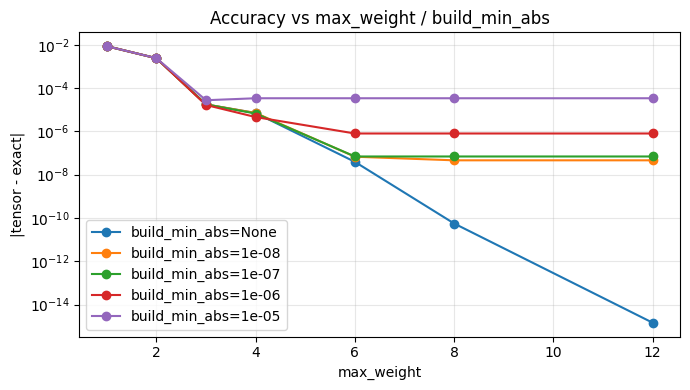

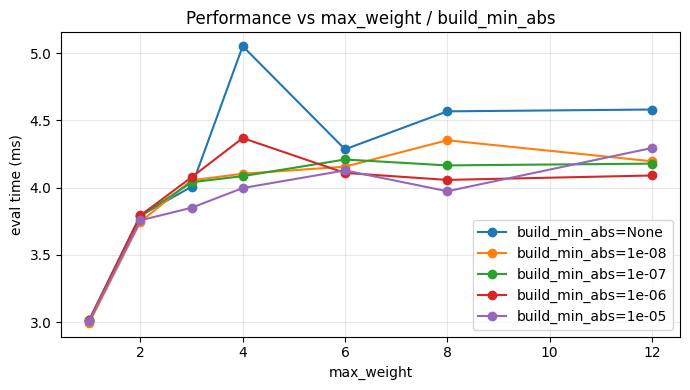

In [5]:
import numpy as np
import time

def _step_nnz(psum):
    total = 0
    for st in psum.steps:
        total += int(st.mat_const._nnz()) + int(st.mat_cos._nnz()) + int(st.mat_sin._nnz())
    return total

def _time_eval(prog, th, runs=40):
    _ = prog.expvals(th, stream_device='cpu', offload_back=False)
    t0 = time.perf_counter()
    for _ in range(runs):
        _ = prog.expvals(th, stream_device='cpu', offload_back=False)
    return (time.perf_counter() - t0) / runs

max_weight_values = [1, 2, 3, 4, 6, 8, 12]
build_min_abs_values = [None, 1e-8, 1e-7, 1e-6, 1e-5]

rows = []
for mw in max_weight_values:
    for bma in build_min_abs_values:
        t0 = time.perf_counter()
        prog = compile_expval_program(
            circuit=circuit,
            observables=obs_exact,
            preset='gpu_min',
            preset_overrides={
                'build_device': 'cuda' if torch.cuda.is_available() else 'cpu',
                'step_device': 'cpu',
                'stream_device': 'cpu',
                'dtype': 'float64',
                'max_weight': 1000000000,
                'max_xy': int(mw),
                'offload_steps': False,
                'offload_back': False,
            },
            build_thetas=thetas,
            build_min_abs=bma,
        )
        compile_s = time.perf_counter() - t0

        val = float(prog.expvals(thetas, stream_device='cpu', offload_back=False)[0].item())
        err = abs(val - exact_ref)
        nnz = _step_nnz(prog.psum_union)
        eval_ms = 1e3 * _time_eval(prog, thetas, runs=40)

        rows.append((mw, bma, compile_s, eval_ms, nnz, val, err))

print('max_weight | build_min_abs | compile(s) | eval(ms) | total_nnz | abs_error')
for mw, bma, cs, ems, nnz, v, e in rows:
    print(f'{mw:>10} | {str(bma):>13} | {cs:9.3f} | {ems:8.3f} | {nnz:9d} | {e:.3e}')

best = sorted(rows, key=lambda r: r[-1])[:10]
print('\nTop-10 accurate configs:')
for mw, bma, cs, ems, nnz, v, e in best:
    print(f'  mw={mw:<2d} bma={str(bma):<8} err={e:.3e} eval_ms={ems:.3f} nnz={nnz}')

try:
    from matplotlib import pyplot as plt
    plt.figure(figsize=(7, 4))
    for bma in build_min_abs_values:
        xs = [mw for mw, bb, *_ in rows if bb == bma]
        ys = [e for mw, bb, *rest in rows if bb == bma for e in [rest[-1]]]
        label = f'build_min_abs={bma}'
        plt.plot(xs, ys, marker='o', label=label)
    plt.yscale('log')
    plt.xlabel('max_weight')
    plt.ylabel('|tensor - exact|')
    plt.title('Accuracy vs max_weight / build_min_abs')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 4))
    for bma in build_min_abs_values:
        xs = [mw for mw, bb, *_ in rows if bb == bma]
        ys = [ems for mw, bb, cs, ems, nnz, v, e in rows if bb == bma]
        label = f'build_min_abs={bma}'
        plt.plot(xs, ys, marker='o', label=label)
    plt.xlabel('max_weight')
    plt.ylabel('eval time (ms)')
    plt.title('Performance vs max_weight / build_min_abs')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception:
    pass


## Notes
- This quickstart is for **tradeoff intuition**: speed vs accuracy.
- If CUDA is unavailable, CPU-only path still provides valid results.
- Exact-reference checks use PennyLane and are practical for small qubit counts (typically <=20).
